To Combine the Different Excel Files into a Single DataFrame for easier analysis in later stages

In [1]:
# Importing the necessary libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import random

In [2]:
# setting default configuration options
pd.set_option("mode.copy_on_write", True)
random.seed(10)

### Identifying the Files

In [3]:
# Setting the Path to the Excel Files
path = "/Users/revanth/Downloads/Messidor/"

In [4]:
# View all the files in the directory
files = os.listdir(path)
files

['Annotation_Base33.xls',
 'Annotation_Base32.xls',
 'Annotation_Base24.xls',
 'Annotation_Base31.xls',
 'Annotation_Base21.xls',
 '.DS_Store',
 'Annotation_Base34.xls',
 'Annotation_Base22.xls',
 'Annotation_Base23.xls',
 'Base11.zip',
 'Base12.zip',
 'Base13.zip',
 'Base14.zip',
 'Base24.zip',
 'Base31.zip',
 'Base33.zip',
 'Base32.zip',
 'Base22.zip',
 'Base23.zip',
 'Base21.zip',
 'Base34.zip',
 'Annotation_Base12.xls',
 'Annotation_Base13.xls',
 'Annotation_Base11.xls',
 'Annotation_Base14.xls',
 'temp_dir']

In [5]:
# Keeping only the Excel Files
files = [f for f in files if f.startswith("Annotation") and f.endswith(".xls")]

# verify that we have 12 files
assert len(files) == 12

### Reading Files

In [6]:
# We will now read the Excel Files
dfs = []
for f in files:
    data = pd.read_excel(path + f)
    dfs.append(data)

# Concatenate all the DataFrames
df = pd.concat(dfs, ignore_index=True)

In [7]:
df.reset_index(drop=True, inplace=True)
df.sample(5)

,Image name,Ophthalmologic department,Retinopathy grade,Risk of macular edema
399,20051130_54121_0400_PP.tif,LaTIM - CHU de BREST,0,0
844,20051214_40994_0100_PP.tif,Service Ophtalmologie Lariboisière,0,0
835,20051213_62705_0100_PP.tif,Service Ophtalmologie Lariboisière,3,0
1132,20060529_56948_0100_PP.tif,Service Ophtalmologie Lariboisière,0,0
122,20051130_55160_0400_PP.tif,LaTIM - CHU de BREST,0,0


## Sanity Checks

In [8]:
# We should have 1200 rows
assert df.shape[0] == 1200

In [9]:
# Ophthlmologic Department Should have 3 unique values
assert df["Ophthalmologic department"].nunique() == 3

In [10]:
# Image name should have no duplicates
assert df["Image name"].nunique() == df.shape[0]

### Modifications

In [11]:
# renaming the columns
df.columns = ["Image_ID", "Department", "Retinopathy_Grade", "Risk_of_Macular_Edema"]

In [12]:
# adding column to specify the data source
df["Data_Source"] = "Messidor"

In [13]:
# viewing the data
df.sample(5)

,Image_ID,Department,Retinopathy_Grade,Risk_of_Macular_Edema,Data_Source
60,20051202_55742_0400_PP.tif,LaTIM - CHU de BREST,2,0,Messidor
195,20051201_38291_0400_PP.tif,LaTIM - CHU de BREST,0,0,Messidor
1068,20051020_64388_0100_PP.tif,Service Ophtalmologie Lariboisière,0,0,Messidor
80,20051205_31949_0400_PP.tif,LaTIM - CHU de BREST,3,0,Messidor
326,20051110_38442_0400_PP.tif,LaTIM - CHU de BREST,0,0,Messidor


### Analysis

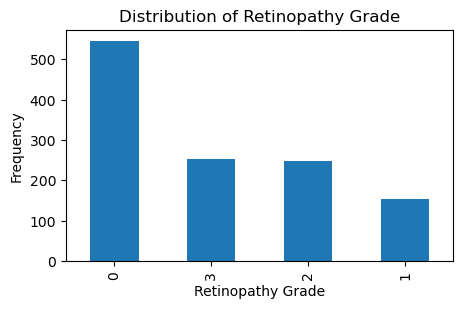

In [14]:
# plotting distribution of the target variable
plt.figure(figsize=(5, 3))
df["Retinopathy_Grade"].value_counts().plot(kind="bar")
plt.title("Distribution of Retinopathy Grade")
plt.xlabel("Retinopathy Grade")
plt.ylabel("Frequency")
plt.show()

<Figure size 500x300 with 0 Axes>

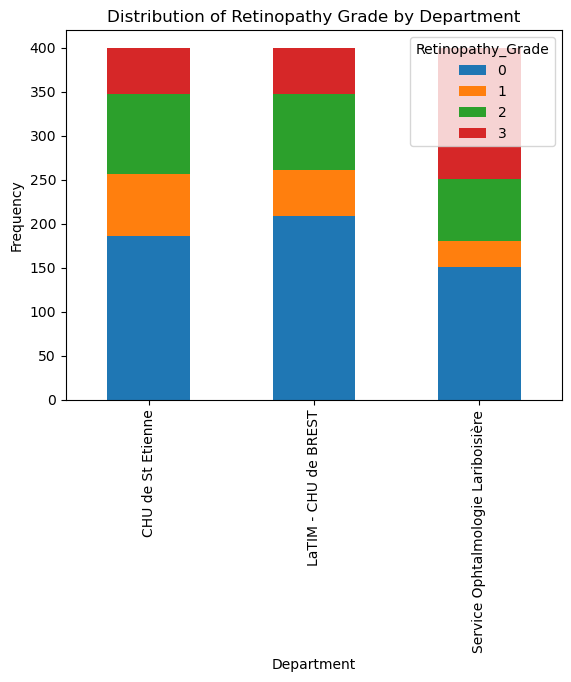

In [15]:
# plotting distribution of the target variable w.r.t the department
plt.figure(figsize=(5, 3))
df.groupby(["Department", "Retinopathy_Grade"]).size().unstack().plot(
    kind="bar", stacked=True
)
plt.title("Distribution of Retinopathy Grade by Department")
plt.xlabel("Department")
plt.ylabel("Frequency")
plt.show()

In [16]:
# viewing split of Department and Retinopathy grade in Test Dataset
df.groupby(["Department", "Retinopathy_Grade"])[
    ["Department", "Retinopathy_Grade"]
].value_counts().reset_index()

,Department,Retinopathy_Grade,count
0,CHU de St Etienne,0,186
1,CHU de St Etienne,1,71
2,CHU de St Etienne,2,91
3,CHU de St Etienne,3,52
4,LaTIM - CHU de BREST,0,209
5,LaTIM - CHU de BREST,1,52
6,LaTIM - CHU de BREST,2,86
7,LaTIM - CHU de BREST,3,53
8,Service Ophtalmologie Lariboisière,0,151
9,Service Ophtalmologie Lariboisière,1,30


### Splitting the Data

Classess have imbalance in them, for the test dataset we will be sampling same number of samples from each class to make the tests consistent

In [17]:
# shuffling the data
df = df.sample(frac=1, random_state=10).reset_index(drop=True)

In [18]:
# getting unique values from the target variable
lst = df["Retinopathy_Grade"].unique()
lst1 = df["Department"].unique()

test_indexes = []

req_samples = 2  # <- number of samples to be taken from each unique combination

# randomly sample X sample indexes from each unique value
for i in lst:
    for j in lst1:
        test_indexes.extend(
            df[(df["Retinopathy_Grade"] == i) & (df["Department"] == j)]
            .sample(req_samples)
            .index
        )

# train indexes
train_indexes = df.index.difference(test_indexes)

In [19]:
# verifying that there is no overlap between the train and test indexes
assert len(set(train_indexes).intersection(set(test_indexes))) == 0

In [20]:
# verifying that the train and test indexes sum up to the total number of samples
assert len(train_indexes) + len(test_indexes) == df.shape[0]

In [21]:
# adding the split column based on the indexes
df["Split"] = "Train"
df.loc[test_indexes, "Split"] = "Test"

### Visual Verification

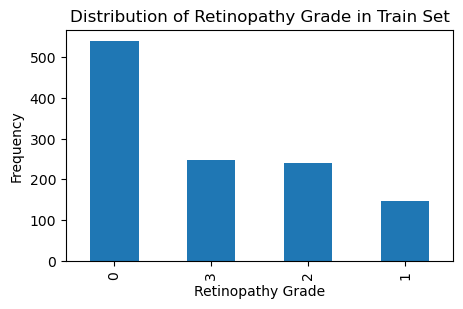

In [22]:
# plotting distribution of the target variable in  Train Set
plt.figure(figsize=(5, 3))
df[df["Split"] == "Train"]["Retinopathy_Grade"].value_counts().plot(kind="bar")
plt.title("Distribution of Retinopathy Grade in Train Set")
plt.xlabel("Retinopathy Grade")
plt.ylabel("Frequency")
plt.show()

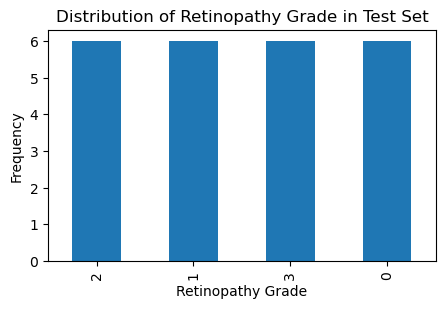

In [23]:
# plotting distribution of the target variable in Test Set
plt.figure(figsize=(5, 3))
df[df["Split"] == "Test"]["Retinopathy_Grade"].value_counts().plot(kind="bar")
plt.title("Distribution of Retinopathy Grade in Test Set")
plt.xlabel("Retinopathy Grade")
plt.ylabel("Frequency")
plt.show()

<Figure size 500x300 with 0 Axes>

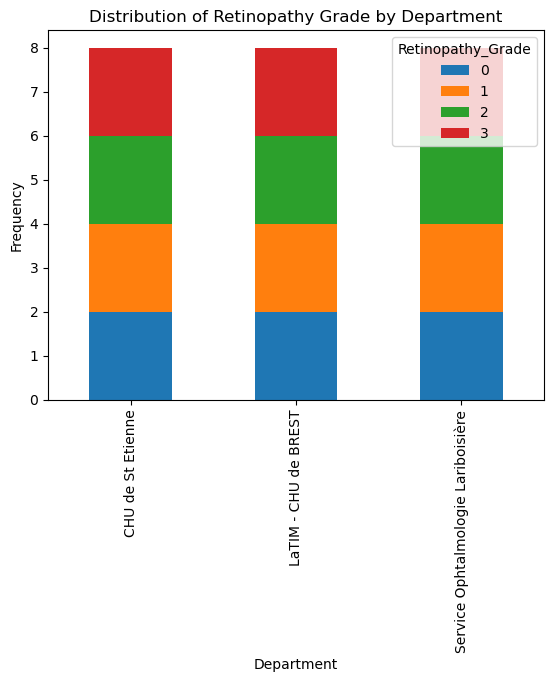

In [24]:
# plotting distribution of the target variable w.r.t the department
plt.figure(figsize=(5, 3))
df[df["Split"] == "Test"].groupby(
    ["Department", "Retinopathy_Grade"]
).size().unstack().plot(kind="bar", stacked=True)
plt.title("Distribution of Retinopathy Grade by Department")
plt.xlabel("Department")
plt.ylabel("Frequency")
plt.show()

In [25]:
# viewing split of Department and Retinopathy grade in Test Dataset
df[df["Split"] == "Test"].groupby(["Department", "Retinopathy_Grade"])[
    ["Department", "Retinopathy_Grade"]
].value_counts().reset_index()

,Department,Retinopathy_Grade,count
0,CHU de St Etienne,0,2
1,CHU de St Etienne,1,2
2,CHU de St Etienne,2,2
3,CHU de St Etienne,3,2
4,LaTIM - CHU de BREST,0,2
5,LaTIM - CHU de BREST,1,2
6,LaTIM - CHU de BREST,2,2
7,LaTIM - CHU de BREST,3,2
8,Service Ophtalmologie Lariboisière,0,2
9,Service Ophtalmologie Lariboisière,1,2


In [26]:
# viewing the data
df.sample(5)

,Image_ID,Department,Retinopathy_Grade,Risk_of_Macular_Edema,Data_Source,Split
419,20060412_52520_0200_PP.tif,CHU de St Etienne,3,0,Messidor,Train
988,20060412_51932_0200_PP.tif,CHU de St Etienne,2,0,Messidor,Train
296,20060523_45389_0100_PP.tif,Service Ophtalmologie Lariboisière,2,2,Messidor,Train
687,20051021_39914_0100_PP.tif,Service Ophtalmologie Lariboisière,0,0,Messidor,Test
86,20060412_51952_0200_PP.tif,CHU de St Etienne,3,2,Messidor,Train


### Saving

In [27]:
# saving df as parquet file

df.to_parquet("../02_Data/Extra/messidor_combine.parquet", index=False)